# Introduction to Spectral Analysis

In this assignment, we will look at the basics of spectral analysis.  As complex-valued or bivariate data is quite common in the earth sciences, we will work with horizontal velocity data from an oceanographic current meter. 

For this assignment, we are going to use a mooring from the Labrador Current on the west side of the Labrador Sea known as the ‘m1244’ mooring. Please download my version of it [here](https://www.dropbox.com/s/yvffwaspom6p443/m1244.mat?dl=0) and put it on your Matlab search path if you have not done so already. (This is included in the full distribution of the course materials.)

This notebook requires my [jlab](http://www.jmlilly.net/software.html) toolbox to be installed.  You will also need to have set up Jupyter Lab to work with Matlab, following [these instructions](http://www.jmlilly.net/jupyter-matlab).

Let's take a quick look at the dataset.

In [1]:
set(groot,'defaultfigurepaperposition',[1 1 8 5]) %set default figure size

load m1244
m1244

m1244 = struct with fields:
   description: '1244 mooring 1994-1995'
           link: 'https://www.nodc.noaa.gov/woce/woce_v3/wocedata_1/cmdac/netcdf/acm29/acm29.htm'
        creator: 'Created by the L_M1244 script by J.M. Lilly'
      timestamp: '18-Oct-2018 05:40:00'
            lat: 55.4786
            lon: -53.6550
         depths: [201 1001 1501 2751]
            num: [7371x1 double]
              p: [7371x4 double]
              t: [7371x4 double]
             cv: [7371x4 double]

# The Periodogram, a.k.a. the Naive Spectral Estimate

The first point to know is that the spectrum is not something that can be computed.  Instead, it is estimated.  The true spectrum is a theoretical object that can't be computed unless you have an infinite amount of time and perfect sampling.  The things that can be computed are called spectral estimates or estimated spectra.  

Firstly, we will look at the modulus-squared Fourier transform.  It is common for this to be referred to as ‘the spectrum’.  However, this terminology is incorrect and misleading.  Instead, the modulus-squared Fourier transform is a type of spectral estimate called the *periodogram*.  It is known, actually, to be a very poor spectral estimate for reasons we will learn about in the course notes. 

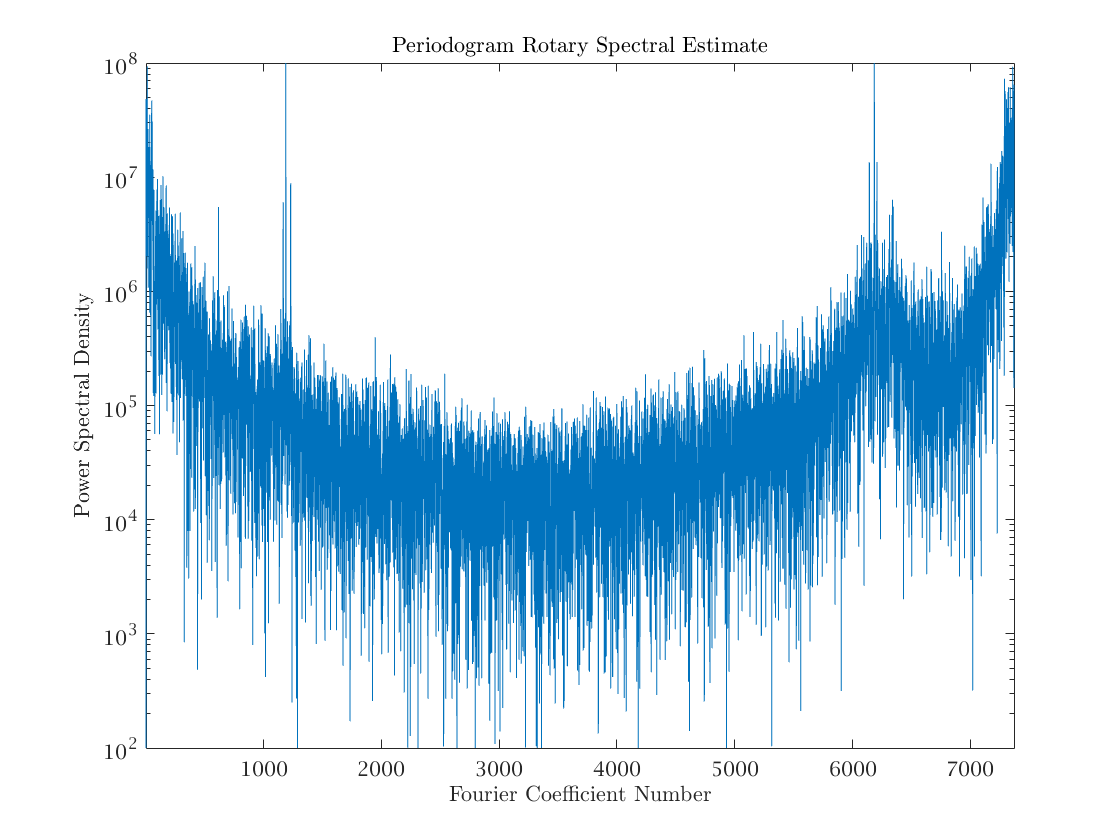

In [2]:
use m1244  %this maps the fields from the m1244 structure into variables in memory
cv=cv(:,4); %we'll work with the fourth or deepest depth henceforth
plot(abs(fft(cv-mean(cv))).^2),axis tight,ylog,ylim(10.^[2 8])
xlabel('Fourier Coefficient Number')
ylabel('Power Spectral Density')
title('Periodogram Rotary Spectral Estimate')

The x-axis is simply the index number of the terms in the squared discrete Fourier transform.

Here we have set the y-axis to be logarithmic.  This is often useful in dealing with spectra.  Note also that we have removed the mean prior to taking the fft, which minimizes broadband bias from the zero frequency. 

In the array output by fft, positive frequencies (circles rotating in a counterclockwise sense) are on the left, while negative frequencies (circles rotating in a clockwise sense) are on the right, appearing in reverse order as we have discussed in class.  Thus the highest resolvable frequency, called the Nyquist frequency, is in the middle.  

You can see clearly that the periodogram roughly has a certain symmetry if you reflect it about the middle. However, it is not completely symmetric because, with a complex-valued signal such as velocity, the twin frequencies (positive and negative rotations at the same absolute frequency) are not required to cancel. 

We will discuss the nature of the features we see here shortly.  For the moment, we compare this with the periodogram of just the eastward velocity, the real part of our complex-valued velocity time series:

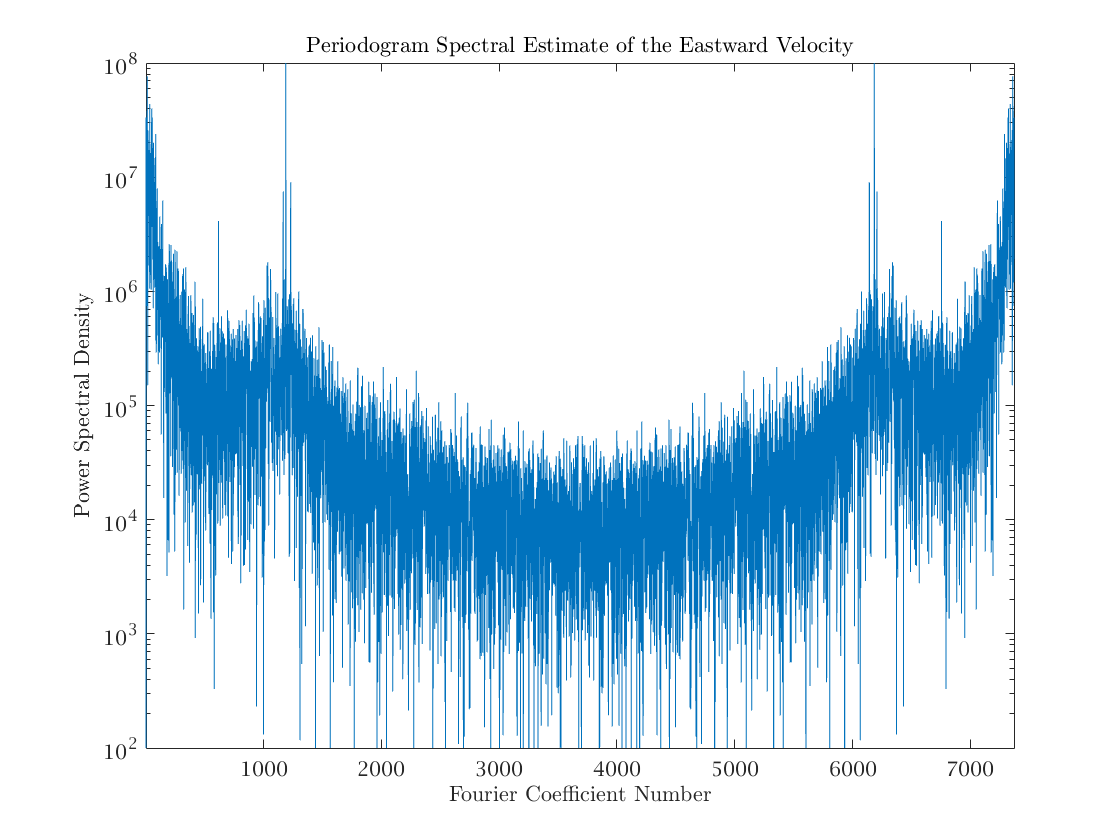

In [3]:
plot(abs(fft(real(cv-mean(cv)))).^2),axis tight,ylog,ylim(10.^[2 8])
xlabel('Fourier Coefficient Number')
ylabel('Power Spectral Density')
title('Periodogram Spectral Estimate of the Eastward Velocity')

Now, the periodogram is perfectly symmetric about the center or Nyquist frequency.  As discussed in the course notes, twin frequencies occur in conjugate pairs, with the same magnitudes but reversed phase.  Because of this, two complex exponentials rotating in opposite directions cancel to yield a real-valued, phase-shifted sinuosoid. The symmetry we see in the periodogram is a reflection of the fact that the time series is real-valued.

Adding two oppositely-rotating circles in general leads to an ellipse.  When the magnitude of one circle vanishes the result is a circle.  When the magnitude of both circles are identical, the result is a line, and this is the case for a real-valued time series.

# One-Sided Spectra

There are several inconvenient aspects of presenting the periodogram in this way.  Firstly, it is a little bit of a hassle to figure out where the frequencies are.  Secondly, it is a bit odd to see the positive and negative frequencies meet in the middle at the Nyquist. Thirdly, the y-axis should be normalized in a meaningful way.  

We'll make a new plot that addresses these issues.

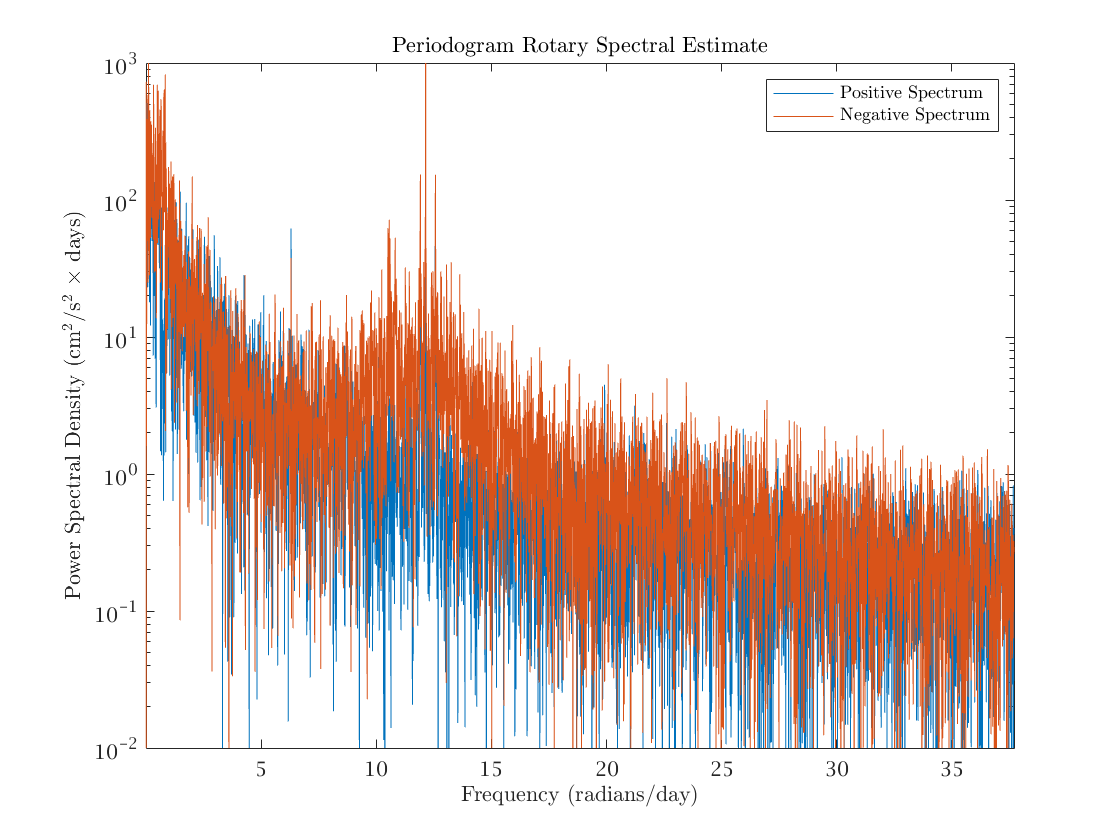

In [4]:
dt=(num(2)-num(1)); %Sampling interval dt in days
[omega,spp,snn]=mspec(dt,cv,[]); %the jlab function mspec with an empty argument returns the periodogram 
h=plot(omega,[spp snn]);axis tight,ylog,ylim(10.^[-2 3])
xlabel('Frequency (radians/day)')
ylabel('Power Spectral Density (cm$^2$/s$^2$ $\times$ days)')
legend(h,'Positive Spectrum','Negative Spectrum')
title('Periodogram Rotary Spectral Estimate')

Here the two-sided periodgram has been split into two one-sided portions, called the positive and negative rotary spectra, each containing roughly half as many data points as the original time series.  Their structure is still hard to see at the moment; we will get to that later.

We have also normalized the y-axis in a sensible way.  The spectrum integrates to the variance, so we would like our spectral estimate to do so, too.  For two one-sided spectra with an odd number of points, using radian frequency, the correct formula to recover the variance is

In [5]:
(1/2/pi)*(omega(2)-omega(1))*sum(spp(2:end)+snn(2:end))
omega(2)-omega(1)

ans = 
   94.5526

ans = 
   0.0102

in which we sum over all frequencies, omitting the first, the zero frequency, from both portions. The omega(2)-omega(1)is a differential, as would appear in an intergal.  When we compare this to the directly computed variance, we find

In [6]:
std(cv,1).^2

ans = 
   94.5526

verifying that our spectral estimate is correctly normalized to obtain the variance as computed in the time domain. These numbers imply a standard deviation of $\sigma=\sqrt{94.5}=9.7$ cm/s.

This explains the units of the spectrum.  Its units must the square of whatever the units are of your time series, in this case cm/s, divided by the frequency units, in this case 1/days (recall that radians are dimensionless).  This is because the spectrum is a partitioning of variance across frequencies.   

# Radian and Cyclic Frequencies
Next we put down some markers of some meaningful frequencies: the Coriolis frequency at the latitude of the mooring location---around which the oceanic internal wave field is concentrated---and eight prominent tidal frequencies.

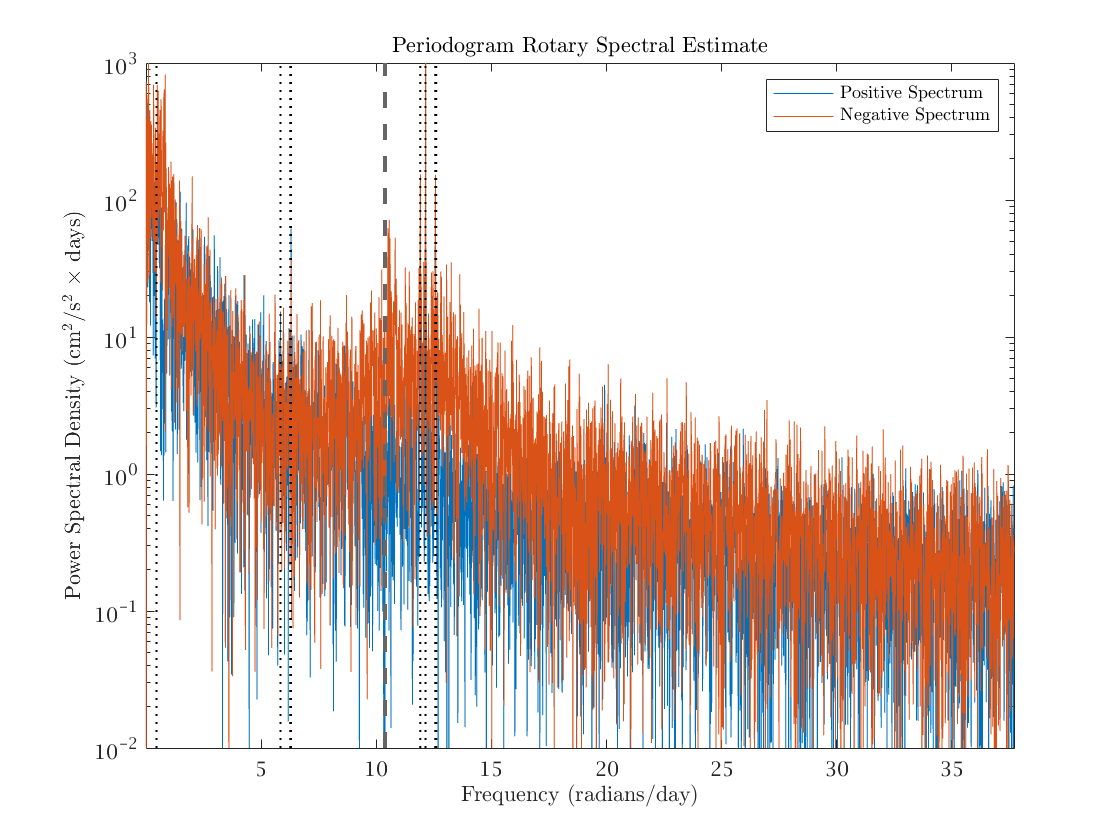

In [7]:
h=plot(omega,[spp snn]);axis tight,ylog,ylim(10.^[-2 3])
vlines(corfreq(lat)*24,'2G--') %lat is the latitude of the mooring
vlines(tidefreq*24,':') %eight major tidal frequencies
%corfreq and tidefreq are jLab functions that output rad/hour, so we convert to rad/day
xlabel('Frequency (radians/day)')
ylabel('Power Spectral Density (cm$^2$/s$^2$ $\times$ days)')
legend(h,'Positive Spectrum','Negative Spectrum')
title('Periodogram Rotary Spectral Estimate')

The tidal frequencies appear in three groups.  From right to left, there are four semidiurnal tidal frequencies, three diurnal frequencies, and one low-frequency tide, the Mf lunal fortnightly tide at about one cycle per 13.6 days. 

As we have discussed, when a frequency is expressed in units of radians per unit time, it is called a radian or angular frequency.  When a frequency is expressed in units of cycles per unit time, it is called a cyclic frequency.  This is more easily seen in how one writes sinusoid or a complex exponential:

\begin{equation} 
e^{i \omega t}~~~(\mathrm{radian}) \quad\quad \mathrm{vs.}\quad\quad e^{2\pi i f t}~~~(\mathrm{cyclic})
\end{equation}
    
Thus the relationship between the radian frequency $\omega$ and the cyclic frequency $f$ is $f=\omega/2\pi$.

I find it useful to work with both types of frequencies.  Radian frequencies are convenient for theoretical expressions.  However, cyclic frequencies are more intutive and therefore to be preferred when plotting or quoting values.

So now we redo the above plot in cyclic frequency, and covert from radians per day to cycles per day.

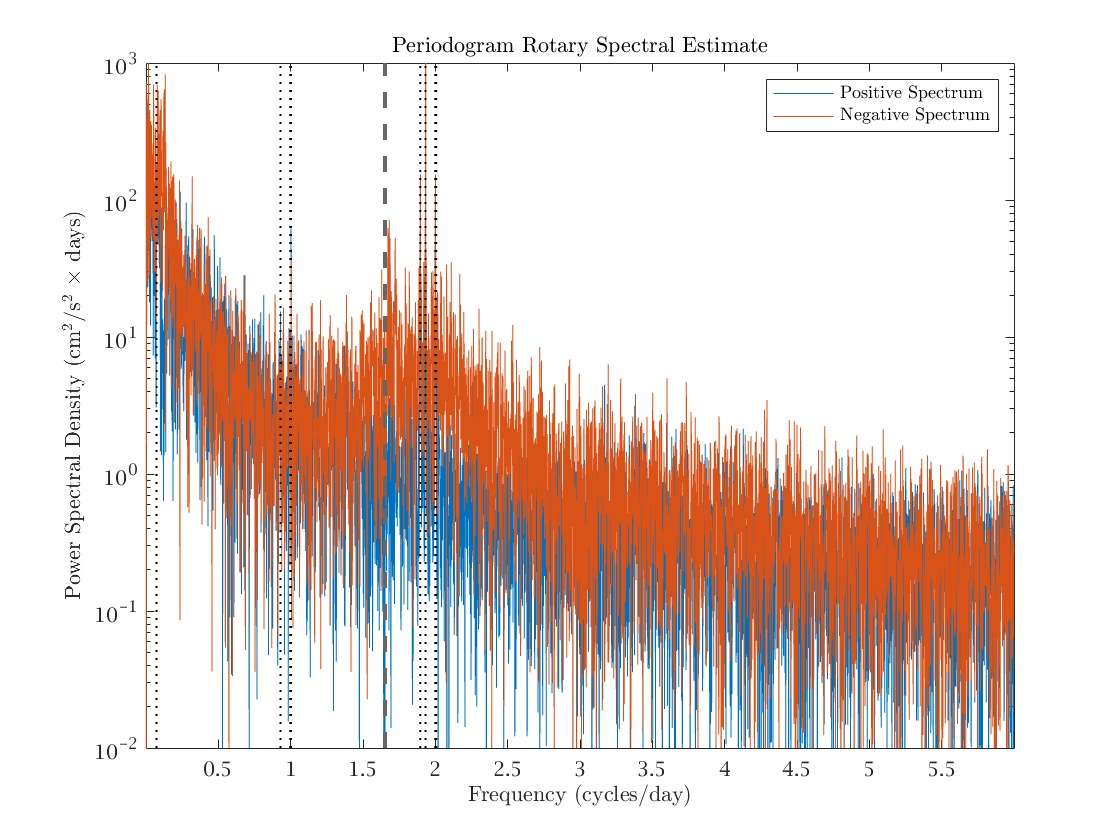

In [8]:
[f,spp,snn]=mspec(dt,cv,[],'cyclic'); %specify to mspec to output cyclic frequencies
h=plot(f,[spp snn]);axis tight,ylog,ylim(10.^([-2 3]))
vlines(corfreq(lat)/2/pi*24,'2G--'),vlines(tidefreq/2/pi*24,':')
xlabel('Frequency (cycles/day)')
ylabel('Power Spectral Density (cm$^2$/s$^2$ $\times$ days)')
legend(h,'Positive Spectrum','Negative Spectrum')
title('Periodogram Rotary Spectral Estimate')

We see that the group of semidiurnal tides occur at 2 cycles per day, as expected.  

Note that changing to cycles per day has also changed the y-level of the spectral estimate (by absorbing a factor of $1/(2\pi)$), such that the spectral estimate continues to satisfy the normalization discussed earlier:

In [9]:
(f(2)-f(1))*sum(spp(2:end)+snn(2:end))

ans = 
   94.5526

Finally, it is often convenient to look at spectra with log/log axes: 

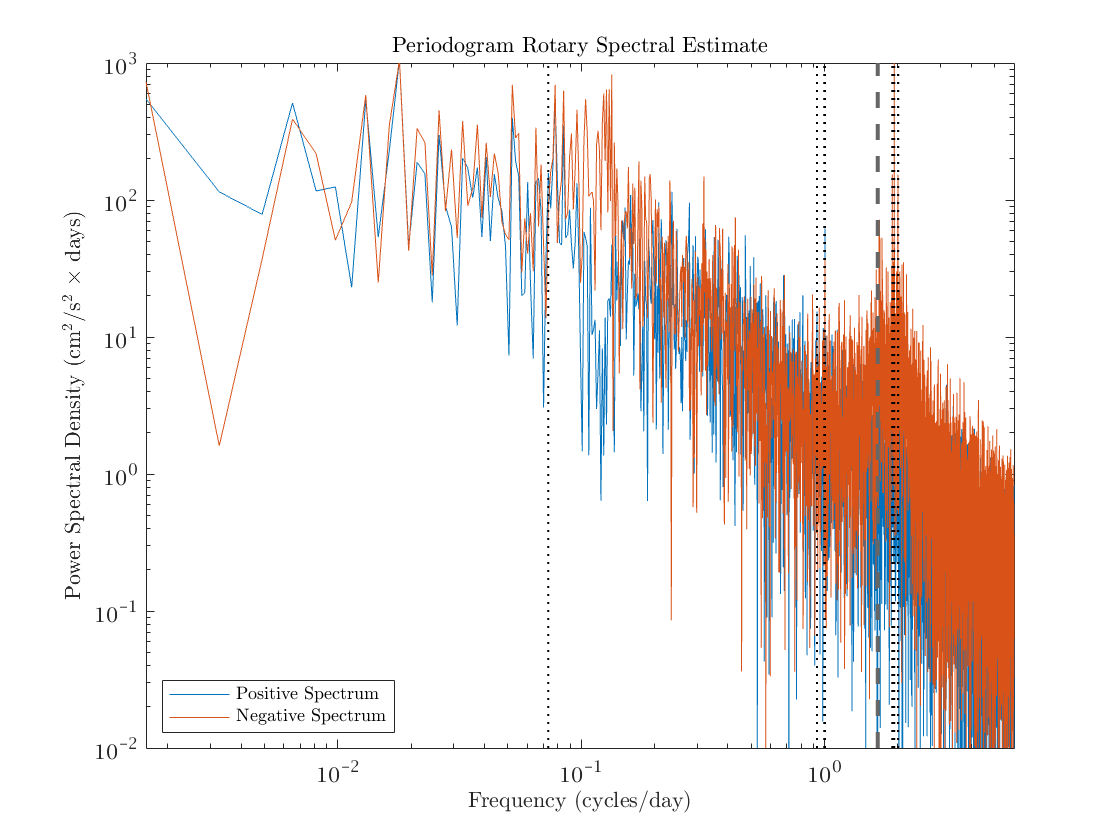

In [10]:
h=plot(f,[spp snn]);xlim([f(2) f(end)]),xlog,ylog,ylim(10.^[-2 3])
vlines(corfreq(lat)/2/pi*24,'2G--'),vlines(tidefreq/2/pi*24,':')
xlabel('Frequency (cycles/day)')
ylabel('Power Spectral Density (cm$^2$/s$^2$ $\times$ days)')
legend(h,'Positive Spectrum','Negative Spectrum','location','southwest');
title('Periodogram Rotary Spectral Estimate')

Again we see the tidal frequencies appearing in three groups.  Here, we can see that there are many more points at higher frequencies than at lower frequencies on account of the change to a logarithmic x-axis.  The lowest nonzero frequency, the leftmost frequency appearing in this log-log plot, is an important quantity called the Rayleigh frequency that we have been discussing.  The Rayleigh frequency in cyclic units is simply one over the length of the time series, and is equal to one cycle per 614 days or 0.0016 cycles per day for this time series.

(Note that as an alternative to log/log axes, one sometimes encounters in oceanography something called a "variance preserving spectrum".  This is a [bad idea](https://selipot.github.io/blog/variance-preserving-spectra/) so we won't use it. )

# The Multitaper Method

The periodogram is now presented with meaningful units and on a meaningful frequency axis.  However, we see that it has a very ‘fuzzy’ appearance on account of a high degree of variability.  This high variance of the spectral estimate is a major, but not the only, problem with the periodogram.  To remove this variance, we need to do some type of smoothing or averaging.  The most convenient way to accomplish this is implicitly, through the use of a type of spectral estimate termed the multitaper method.  

For the moment we will plot only the negative or clockwise side, and will try three different degrees of smoothing that we compare with the raw periodogram estimate, which involves no smoothing.

SLEPTAP calculating tapers of length 512.
SLEPTAP calculating tapers of length 512.
SLEPTAP calculating tapers of length 512.


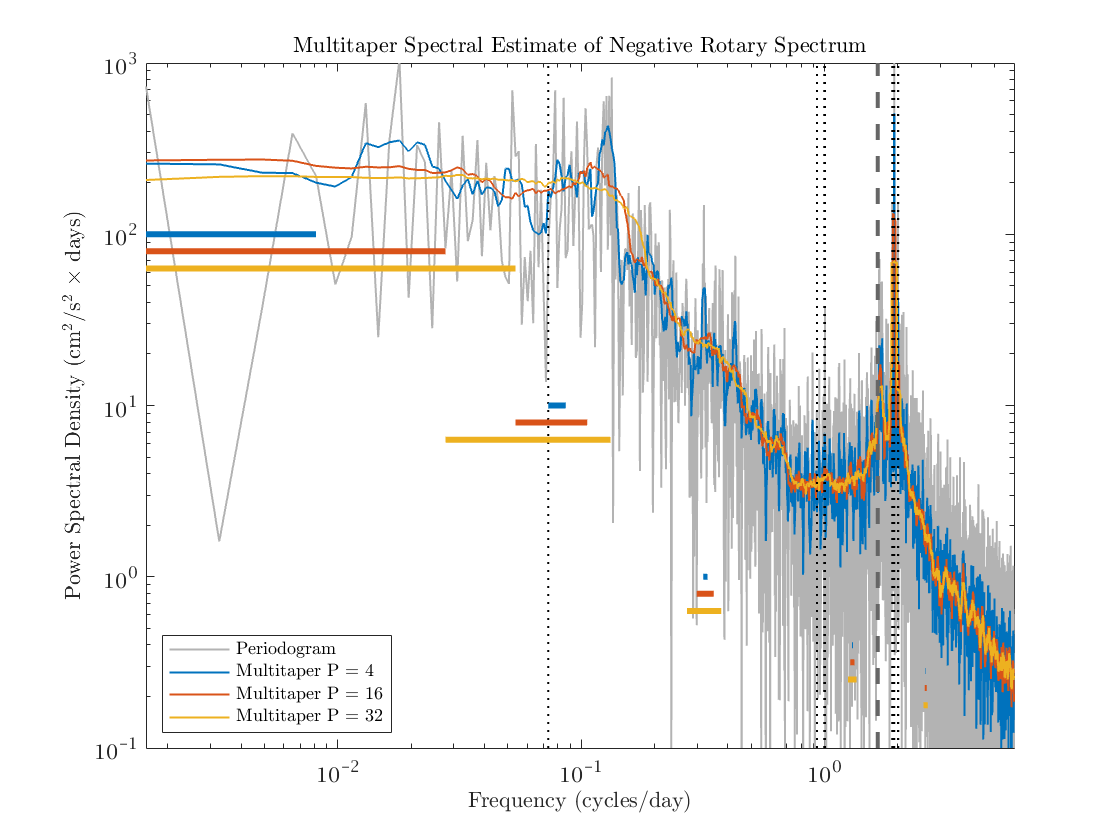

In [11]:
P=[4 16 32];  %three different levels of smoothing
for i=1:length(P)
    psi=sleptap(length(cv),P(i));  
    [f,spp(:,i+1),snn(:,i+1)]=mspec(dt,cv,psi,'cyclic');
end

h=plot(f,snn);xlim([f(2) f(end)]),xlog,ylog,ylim(10.^[-1 3])
linestyle D T U V

vlines(corfreq(lat)/2/pi*24,'2G--')
vlines(tidefreq/2/pi*24,':')

%show smoothing extents at different frequencies
sty='TUV';
for i=1:length(P)
    hl=plot([f(2) f(2+P(i))],[1 1]*10^(2-(i-1)/10));linestyle(hl,['3' sty(i)])
    hl=plot([f(50-P(i)) f(50+P(i))],[1 1]*10^(1-(i-1)/10));linestyle(hl,['3' sty(i)])
    hl=plot([f(200-P(i)) f(200+P(i))],[1 1]*10^(0-(i-1)/10));linestyle(hl,['3' sty(i)])
    hl=plot([f(800-P(i)) f(800+P(i))],[1 1]*10^(-0.4-(i-1)/10));linestyle(hl,['3' sty(i)])
    hl=plot([f(1600-P(i)) f(1600+P(i))],[1 1]*10^(-0.55-(i-1)/10));linestyle(hl,['3' sty(i)])
end

xlabel('Frequency (cycles/day)')
ylabel('Power Spectral Density (cm$^2$/s$^2$ $\times$ days)')
clear str
str{1}='Periodogram';
for i=1:length(P)
    str{i+1}=['Multitaper P = ' int2str(P(i))];
end
legend(h,str,'location','southwest');
title('Multitaper Spectral Estimate of Negative Rotary Spectrum')

The quantity $P$ in the code is called the time-bandwidth product, and it sets the degree of smoothing across frequencies, with a larger $P$ value leading to smoother spectra.

The horizontal lines represent the effective smoothing that has been applied by the multitaper method, which has the effect of smoothing adjacent frequencies in a window that has a width of $2P-1$ Fourier coefficients. For example, with $P=16$ we are essentially smoothing over 31 adjacent frequencies.  The black lines shows the *half-width* of the smoother $(2P-1)/2\approx P$ in the vicinity of the zero frequency, and the full width of $2P-1$ frequencies elsewhere.  

The fact that the apparent width of the smoothing changes is due to the fact that we are presenting this plot with a logarithimic x-axis.  This explains why the spectra appear to become more rough as one moves toward higher frequencies.

In practical terms you simply increases the time-bandwidth product  until you feel you have obtained a suitable degree of smoothing.  Deciding on an appropriate degree of smoothing is generally something that is done by ‘feel’, depending on what features you are interested in investigating, rather than something that has an objectively correct answer.  

When the smoothing is too small, the spectral estimate is poor because of too much variance.  When the smoothing is too large, the spectral estimate is poor not because it varies, but because it is systematically different from the true spectrum; this problem is called bias.  These two problems trade off against each other.  One of the challenges in signal analysis is trying to make a sensible choice in this bias-variance tradeoff. 

# Rotary Spectra

We will now compare the positive and negative rotary spectra using the $P=16$ multitaper estimate.

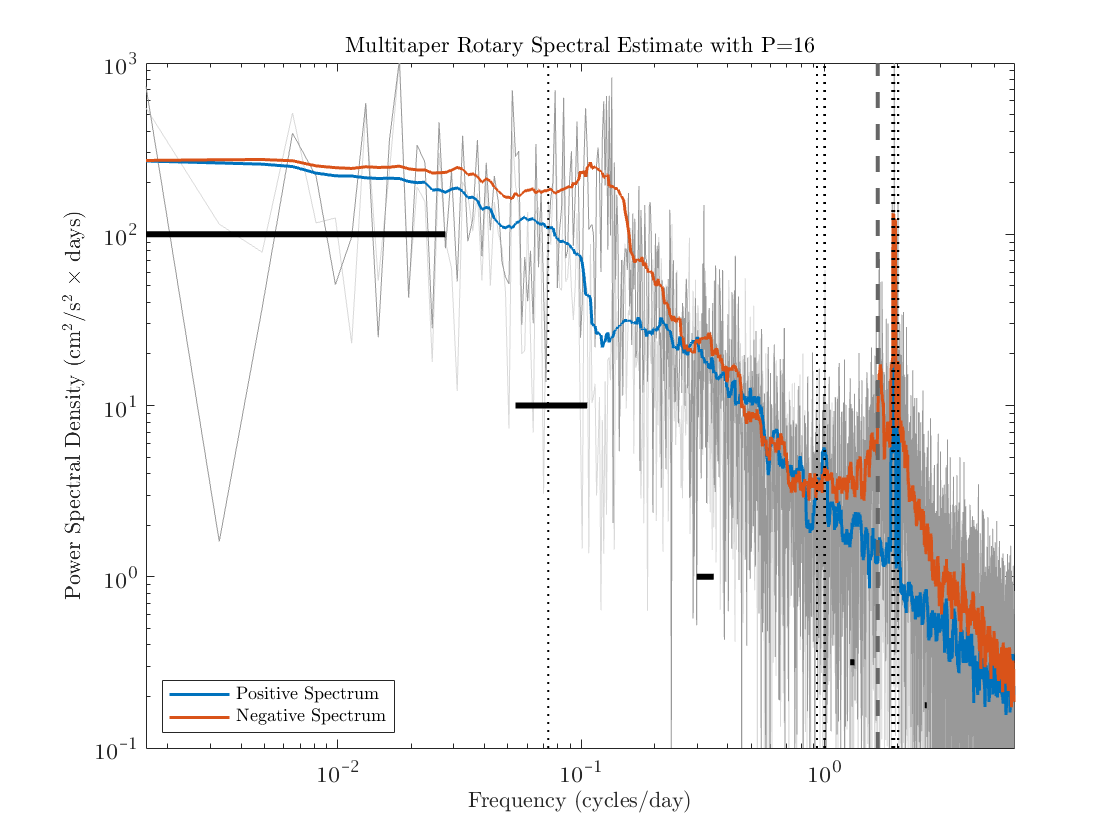

SLEPTAP calculating tapers of length 512.


In [33]:
[f,spp,snn]=mspec(dt,cv,[],'cyclic'); %specify to mspec to output cyclic frequencies
plot(f,spp,'color',[1 1 1]*0.85),hold on,plot(f,snn,'color',[1 1 1]*0.6)

P=16;
psi=sleptap(length(cv),P); 
[f,spp,snn]=mspec(dt,cv,psi,'cyclic');

h=plot(f,[spp snn]);xlim([f(2) f(end)]),xlog,ylog,ylim(10.^[-1 3])
linestyle(h(1),'1.5T')
linestyle(h(2),'1.5U')

vlines(corfreq(lat)/2/pi*24,'2G--')
vlines(tidefreq/2/pi*24,':')

%show smoothing extents at different frequencies
io=[2 50 200 800 1600];yo=[10^2 10^1 10^0 10^(-0.5) 10^(-0.75)];
for i=1:length(io)
    if i==1
        hl=plot([f(io(i)) f(io(i)+P)],[1 1]*yo(i));linestyle(hl,'3k')
    else
        hl=plot([f(io(i)-P) f(io(i)+P)],[1 1]*yo(i));linestyle(hl,'3k')
    end    
end

xlabel('Frequency (cycles/day)')
ylabel('Power Spectral Density (cm$^2$/s$^2$ $\times$ days)')
legend(h,'Positive Spectrum','Negative Spectrum','location','southwest');
title('Multitaper Rotary Spectral Estimate with P=16')

Note the substantial differences between the two sides. On the negative side---the side that supports inertial oscillations in the Northern Hemisphere---we see a broad wave band surrounding the semidiurnal tide, which at this latitude is close to the inertial frequency. These are internal waves clustered around the inertial frequency.  On the positive side, there is a very narrow semidiurnal peak and no broadband peak at all.  

The reason that the orange peak is so narrow is that free waves are not supported on this side. (We know this from our physical understanding of the internal wave dispersion relation for near-inertial waves.) This leads us to hypothesize that the narrow peak on the positive side is the barotropic tide, not the so-called baroclinic tide associated with excited internal waves.  (This could be investigated more by looking at the vertical shear in this frequency band on the two sides of the spectrum.)

Moving towards lower or subinertial frequencies, the positive and negative spectra quickly converge, starting around say one cycle per day.  Here we see that there is background slope that runs continuously through most of the spectrum, with the negatively rotating peak rising above this slope.  Loosely speaking, the slope represents geostrophic turbulence and boundary current variability, while the peak broadband represents inertia-gravity waves.

At still lower frequencies, at say one cycle per ten days, a possible peak is observed in the negatively rotating portion.  We will check in a moment whether that peak is significant. 

Below that, both sides of the spectrum transitions to a constant value.  This transition appears to occur *before* the smoothing width coming from the lowest frequencies is encountered, and therefore appears physically meaningful, i.e. is does not appear to be an artifact of smoothing out the lowest frequencies.  This interpretation is supported by the previous plot, where the low-frequency plateau is still visible using the $P=4$ setting.

Moving to higher frequencies from the inertial peak, the negative spectrum becomes closer to, but remains stronger than, the positive spectrum up to the highest resolvable frequency.  This behavior likely reflects the known polarization behavior for internal waves.

Given the inertial frequency $f_o$ and the buoyancy frequency $N$, the horizontal currents due to internal waves form an ellipse, the eccentricity of which is known as a function of frequency. This ellipse becomes a circle at $f_o$ where the internal waves become pure inertial oscillations, and a straight line at $N$, where the waves become pure internal gravity waves.  Thus, what we are seeing here is the internal wave spectrum becoming more linearly polarized and less circularly polarized---more like gravity waves and less like inertial oscillations---as we head towards the buoyancy frequency.

Let's take a closer look at the near-inertial peak by zooming in. We'll remake the same plot with a tighter x-axis.

SLEPTAP calculating tapers of length 512.


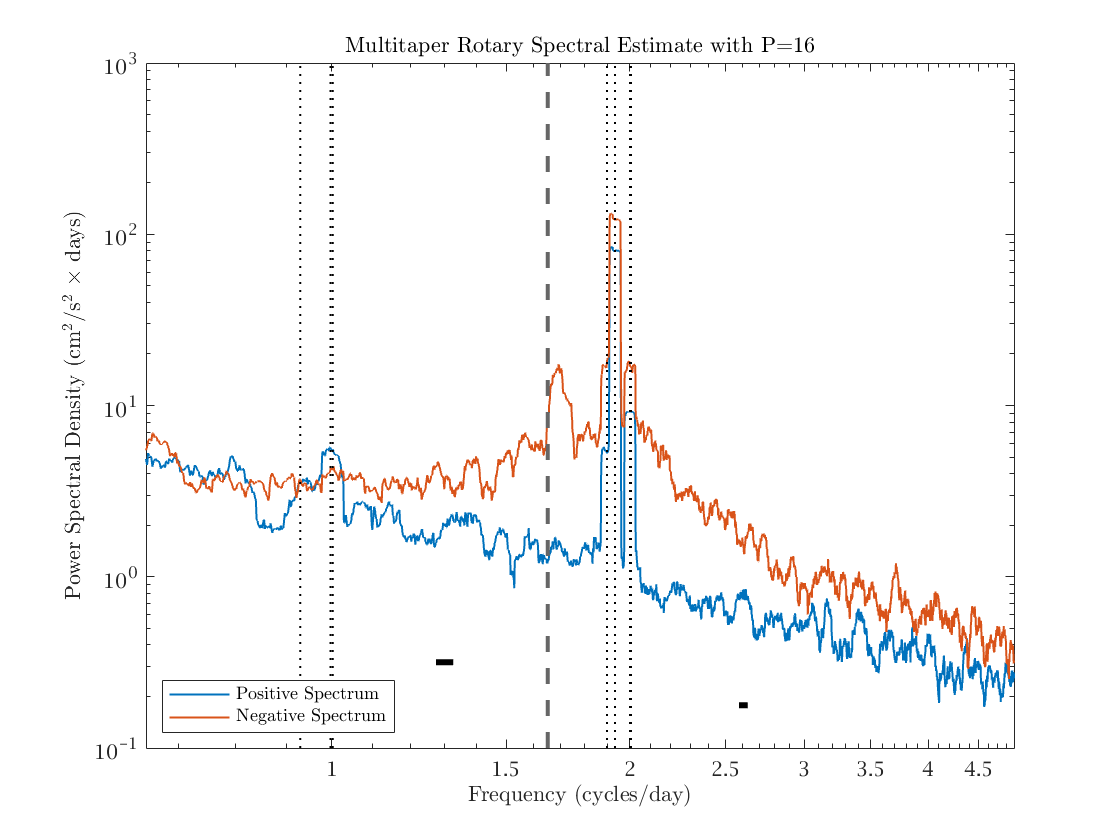

In [13]:
P=16;
psi=sleptap(length(cv),P); 
[f,spp,snn]=mspec(dt,cv,psi,'cyclic');

h=plot(f,[spp snn]);xlim([f(400) f(3000)]),xlog,ylog,ylim(10.^[-1 3])
linestyle T U
vlines(corfreq(lat)/2/pi*24,'2G--')
vlines(tidefreq/2/pi*24,':')

%show smoothing extents at different frequencies
io=[2 50 200 800 1600];yo=[10^2 10^1 10^0 10^(-0.5) 10^(-0.75)];
for i=1:length(io)
    if i==1
        hl=plot([f(io(i)) f(io(i)+P)],[1 1]*yo(i));linestyle(hl,'3k')
    else
        hl=plot([f(io(i)-P) f(io(i)+P)],[1 1]*yo(i));linestyle(hl,'3k')
    end    
end

xlabel('Frequency (cycles/day)')
ylabel('Power Spectral Density (cm$^2$/s$^2$ $\times$ days)')
legend(h,'Positive Spectrum','Negative Spectrum','location','southwest');
title('Multitaper Rotary Spectral Estimate with P=16')

Here we can see that there are actually individual lines for the three different semidiurnal tidal components.  These have significant magitude on both the positive and negatives sides of the specturm, meaning that these oscillations would be elliptically and not circularly polarized.  We could study these tidal oscillations more using a narrowband filter if we wished.  A smaller peak at the some of the diurnal tidal lines is also apparent, but only in the positively rotating component.  

Now let's take a look at the spectral estimates with confidence intervals superposed. Here, we will plot the negative and positive rotary spectral estimates separately.

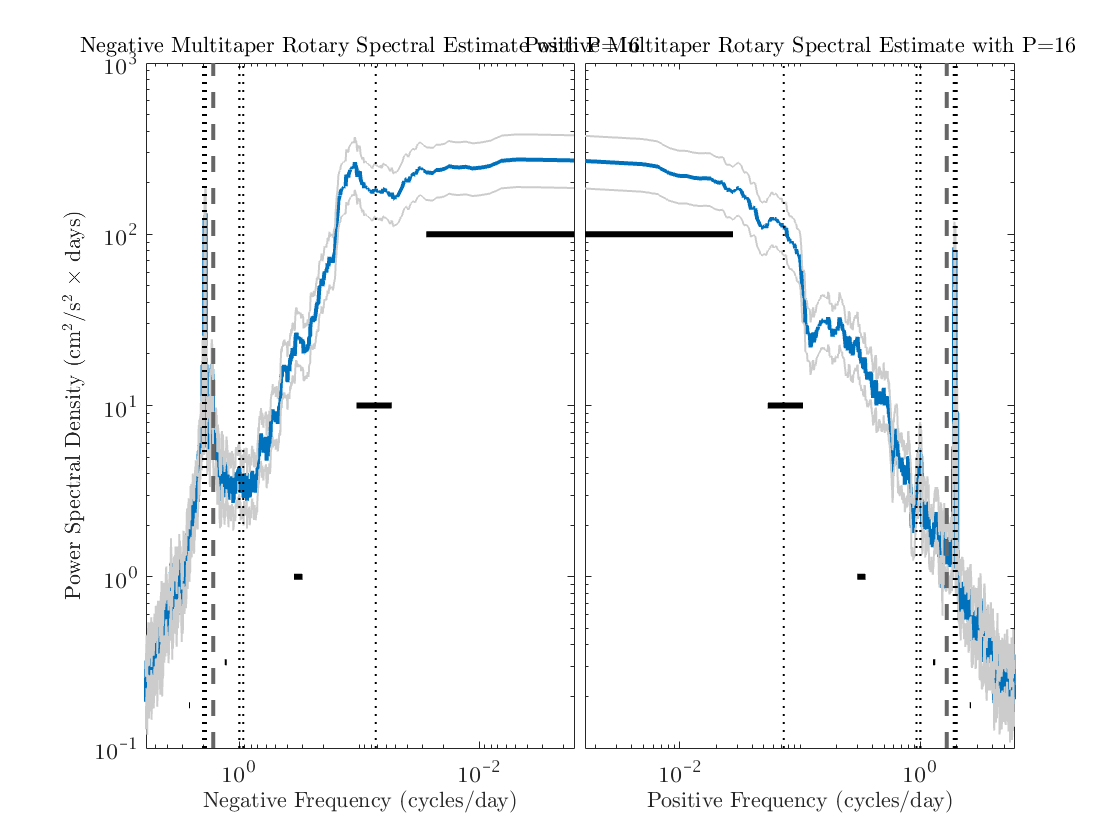

SLEPTAP calculating tapers of length 512.


In [14]:
set(gcf,'paperposition',[1 1 12 5]) %set figure size

P=16;
psi=sleptap(length(cv),P); 
[f,spp,snn]=mspec(dt,cv,psi,'cyclic');
[ra,rb]=mconf(2*P-1,0.95,'log10'); %compute confidence intervals

for i=1:2
    subplot(1,2,i)
    if i==1
        plot(f,snn,'linewidth',2);hold on
        h=plot(f,[10^ra 10^rb].*snn);linestyle(h,'C')
        flipx
        title('Negative Multitaper Rotary Spectral Estimate with P=16')
        xlabel('Negative Frequency (cycles/day)')
    elseif i==2
        plot(f,spp,'linewidth',2); hold on
        h=plot(f,[10^ra 10^rb].*spp);linestyle(h,'C')
        title('Positive Multitaper Rotary Spectral Estimate with P=16')
        xlabel('Positive Frequency (cycles/day)')
    end
         
    xlim([f(2) f(end)]),xlog,ylog,ylim(10.^[-1 3])
    vlines(corfreq(lat)/2/pi*24,'2G--')
    vlines(tidefreq/2/pi*24,':')

    %show smoothing extents at different frequencies
    io=[2 50 200 800 1600];yo=[10^2 10^1 10^0 10^(-0.5) 10^(-0.75)];
    for i=1:length(io)
        if i==1
            hl=plot([f(io(i)) f(io(i)+P)],[1 1]*yo(i));linestyle(hl,'3k')
        else
            hl=plot([f(io(i)-P) f(io(i)+P)],[1 1]*yo(i));linestyle(hl,'3k')
        end    
    end
    ylabel('Power Spectral Density (cm$^2$/s$^2$ $\times$ days)')
end
packfig(1,2)

Based on our understanding of the statistical properities of the multitaper spectral estimate, the true spectrum should lie within the gray lines 95% probability.  This means the near-inertial peak is highly statistically sigificant, whereas the low-frequency peak on the negative side is just barely signficant at the 95% level.  Most of the other peaks and valleys we see along the sloping portion of the spectra are within the expected envelope of random fluctuations and are therefore not significant. 

# Cartesian Spectra

Next we will compare the rotary spectra with the Cartesian spectra. We will learn more about this in class, however, the basic idea is that we have a choice as to how to split up the spectrum of our complex-valued velocity signal $z=u+iv$.  We can choose to look at the rotary spectrum, separating positive and negative frequencies, or alternatively, we can choose to look at the spectra of $u$ and $v$ considered separately.  We refer to the resulting pair of one-sides spectra as the Cartesian spectra, to distinguish these from the rotary spectra.

Here we will look not at the Cartesian spectra in the usual eastward / northward coordinate system, but rather in a frame aligned with the mean flow.  We do this by defining a rotated time series $\tilde z =\tilde u+ i\tilde v=z e^{-i\phi}$ where $\phi$ is the direction of the mean flow. 

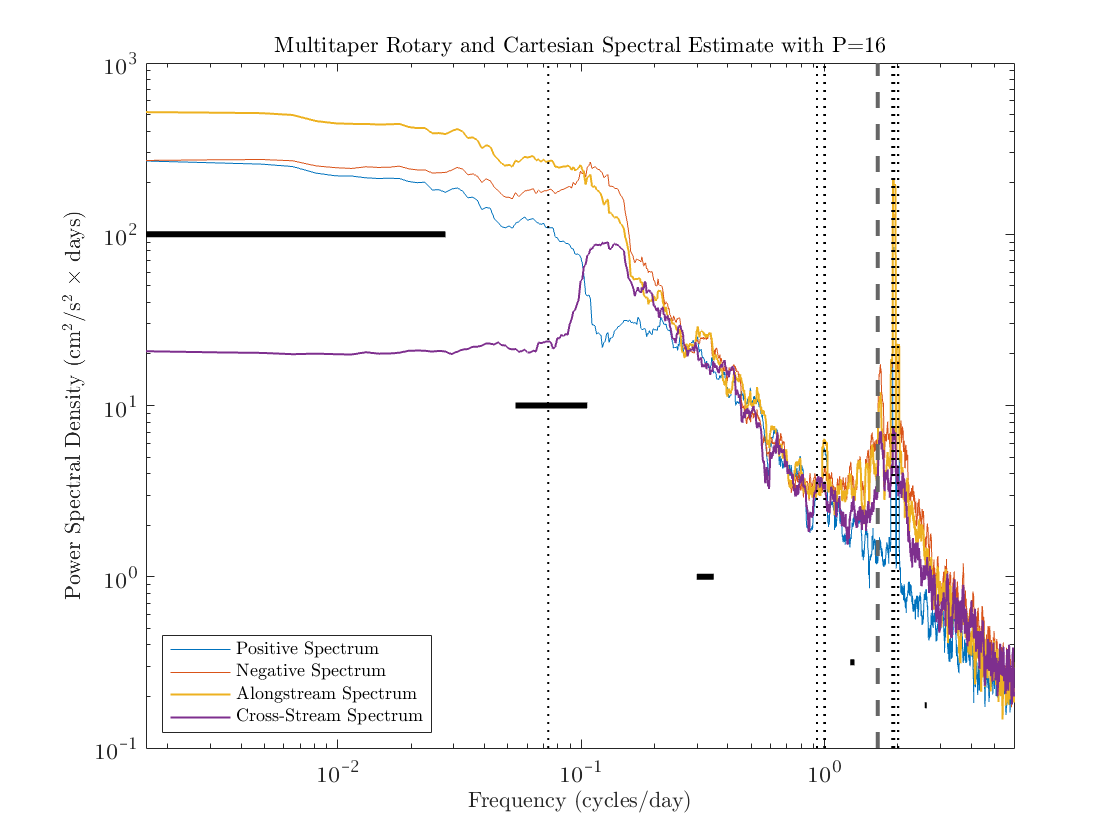

In [15]:
phi=angle(mean(cv));
rcv=cv*exp(-1i*phi);  %Define a rotated version of the velocity 

[f,suu,svv]=mspec(dt,real(rcv),imag(rcv),psi,'cyclic');
[f,spp,snn]=mspec(dt,cv,psi,'cyclic');

h=plot(f,[spp snn 2*suu 2*svv]);xlim([f(2) f(end)]),xlog,ylog,ylim(10.^[-1 3])
%the factors of two are needed because the usual definition of the Cartesian spectra
%considers them to be two-sided (supported on both positive and negative frequencis)
%whereas here we consider them to be one-sided

linestyle 0.5T 0.5U V W
vlines(corfreq(lat)/2/pi*24,'2G--')
vlines(tidefreq/2/pi*24,':')

%show smoothing extents at different frequencies
io=[2 50 200 800 1600];yo=[10^2 10^1 10^0 10^(-0.5) 10^(-0.75)];
for i=1:length(io)
    if i==1
        hl=plot([f(io(i)) f(io(i)+P)],[1 1]*yo(i));linestyle(hl,'3k')
    else
        hl=plot([f(io(i)-P) f(io(i)+P)],[1 1]*yo(i));linestyle(hl,'3k')
    end    
end

xlabel('Frequency (cycles/day)')
ylabel('Power Spectral Density (cm$^2$/s$^2$ $\times$ days)')
legend(h,'Positive Spectrum','Negative Spectrum','Alongstream Spectrum','Cross-Stream Spectrum','location','southwest');
title('Multitaper Rotary and Cartesian Spectral Estimate with P=16')

At low frequencies, we see some very interesting behavior.  The low-frequency plateau is associated with the along-stream currents, where we see the along-stream spectrum is more than an order of magnitude stronger than the cross-stream spectrum.  This is not unsurprising and likely reflects seasonal or other low-frequency variability in the current strength.  

The peak we saw on around one cycle per 10 days in the negative rotary spectrum now appears to be associated with a promient peak in the cross-stream currents.  It is unclear whether this represents a quasi-peridodic fluctuation of the cross-stream currents at that frequency, or whether we should interpret this as meaning that lower frequency fluctuations of the cross-stream currents are somehow suppressed or diminished.  In either case, the low-frequency bevahior appears to more suitably decomposed into its along- and cross-stream components rather than the rotary components.

A rule of thumb is that a phenomena is most compactly described by the spectral pair exhibiting the highest degree of anisotropy. In the inertial band, we see a much higher degree of anisotropy for the rotary pairing than for the Cartesian pairing.  This occurs because the near-inertial band consists of nearly circular ellipses. In that band, the near-inertial variability projects strongly onto both Cartesian components. 

The point is that whether the rotary or Cartesian perspective on the spectra is most suitable is not a property of the time series. Rather is it a property of the phenomenon. Even within one time series, we may need to use different perspectives to best analyze phenomena at different frequencies. In general, you should always look at the rotary spectrum, and also the Cartesian spectra rotated either to align with the bathymetry, or the mean current, or the direction of highest variance.

# Summary

This lab has walked you through how to choose multi-taper spectral estimation, how these relate to the raw Fourier coefficients, and also how to begin interpreting what you see.  You can now try to apply some of the ideas to your own time series.

A few notes: (i) If you don't have complex-valued data, then you only have one spectrum per time series, and the rotary spectra decomposition is not useful. (ii) The periodogram is only shown to illustrate the improvement that we made when we switched to the multitaper estimate.  Please do not interpret this as suggesting that the periodogram is something you are supposed to look at and analyze.  

# The End

